<a href="https://colab.research.google.com/github/will-cotton4/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
# We'd like to measure health outcome
# y = "health level" dependent var.
# x = "took the drug" independent var.

In [0]:
import random
random.seed(42)
# dir(random)  # Reminding ourselves what we can do here

In [29]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [30]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=150.42273427770718, mobile=False), User(purchased=True, time_on_site=284.06235530493245, mobile=True), User(purchased=True, time_on_site=140.37976895454653, mobile=True), User(purchased=True, time_on_site=49.206452507812216, mobile=True), User(purchased=False, time_on_site=167.81563803588924, mobile=True), User(purchased=False, time_on_site=20.484876517641524, mobile=True), User(purchased=False, time_on_site=167.3540069049869, mobile=True), User(purchased=False, time_on_site=447.75054592529114, mobile=False), User(purchased=True, time_on_site=57.93525538719398, mobile=True), User(purchased=True, time_on_site=292.6494305470663, mobile=True)]


In [31]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,150.422734,False
1,True,284.062355,True
2,True,140.379769,True
3,True,49.206453,True
4,False,167.815638,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

In [32]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,227,238,111,23,37
True,106,133,84,20,21


In [33]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')



time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,0.681682,0.641509,0.569231,0.534884,0.637931
True,0.318318,0.358491,0.430769,0.465116,0.362069


# Experiment with graph

In [0]:
import matplotlib.pyplot as plt
import numpy as np
# objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(time_bins))
performance = [10,8,6,4,2,1]
print(user_data['purchased'].dtype)

# plt.bar(y_pos, user_data['purchased'][], align='center', alpha=0.5)
# plt.xticks(y_pos, time_bins)
# plt.ylabel('Time Spent on Site')
# plt.title('Likelihood')
# plt.show() 
# plt.bar(user_data['purchased'], time_bins, align='center', alpha=0.5)

# Resume lecture notebook

In [34]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.704,0.613333
True,0.296,0.386667


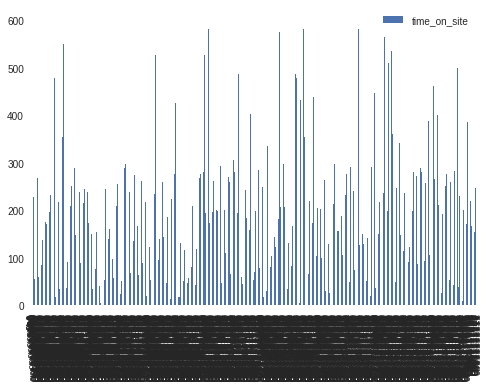

In [38]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins],
            rownames=['device'], 
            colnames=['purchased', 'time_on_site'], normalize='index')
pd.pivot_table(user_data, values='time_on_site', index=bin).plot.bar()


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [40]:
# TODO - your code here
# Use what we did live in lecture as an example

# I decided it would be easier to just download the file and fix the header manually.

from google.colab import files
uploaded = files.upload()

# HINT - you can find the raw URL on GitHub and potentially use that

# to load the data with read_csv, or you can upload it yourself

Saving persons.csv to persons.csv


In [44]:
import io
persons_data = pd.read_csv(io.BytesIO(uploaded['persons.csv']))
persons_data.head()

,uuid,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [49]:
persons_data.corr()

,uuid,age,weight,exercise_time
uuid,1.000000,-0.000418,-0.060297,-0.020138
age,-0.000418,1.000000,0.144168,-0.273818
weight,-0.060297,0.144168,1.000000,-0.478021
exercise_time,-0.020138,-0.273818,-0.478021,1.000000


#### Looks like, considered individually, all the variables have a fairly weak correlation. Let's use some more sophisticated models to see if we can make this a bit better.

First, we can check out a few pairplots and see what shows up:

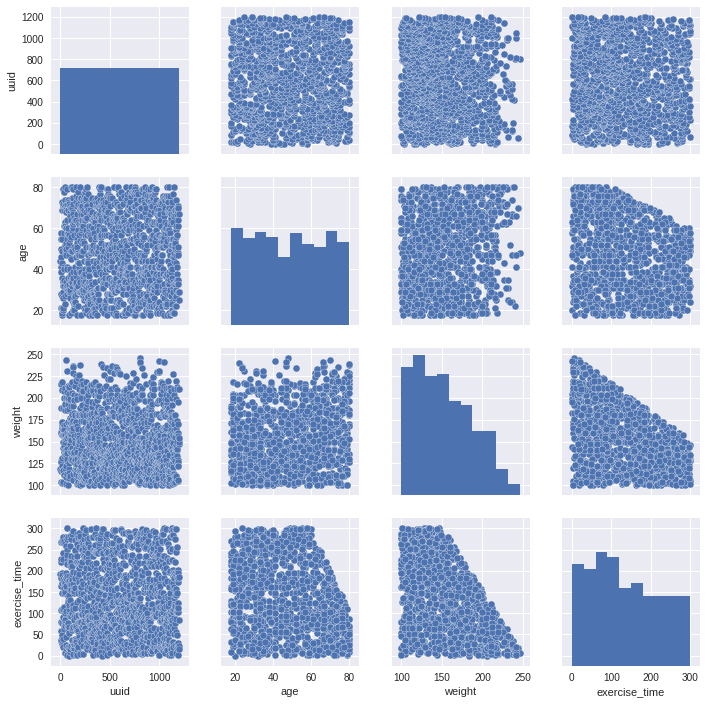

In [51]:
import seaborn as sns
pair_plots = sns.pairplot(persons_data)

#### Interesting. It looks like there's not really a correlation between weight and exercise time or between age and exercise time, but weight and age seem to impose an upper bound on exercise time; people over age 80 don't seem to exercise for much longer than a couple hours a week (assuming that time here is measured in minutes per week). That makes intuitive sense.

Let's check out some crosstabs.

In [63]:
#First, we bin the data to make things a bit more manageable.

weight_bins = pd.cut(persons_data['weight'], 5)  # 5 equal-sized bins
age_bins = pd.cut(persons_data['age'], 10)
exercise_bins = pd.cut(persons_data['exercise_time'], 3)
pd.crosstab(exercise_bins, weight_bins, normalize='columns')

weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]"
exercise_time,,,,,
"(-0.3, 100.0]",0.245333,0.307463,0.492248,0.726257,1.0
"(100.0, 200.0]",0.333333,0.319403,0.399225,0.273743,0.0
"(200.0, 300.0]",0.421333,0.373134,0.108527,0.000000,0.0


In [64]:
# Let's compare age and exercise time too.

pd.crosstab(exercise_bins, age_bins, normalize='columns')

age,"(17.938, 24.2]","(24.2, 30.4]","(30.4, 36.6]","(36.6, 42.8]","(42.8, 49.0]","(49.0, 55.2]","(55.2, 61.4]","(61.4, 67.6]","(67.6, 73.8]","(73.8, 80.0]"
exercise_time,,,,,,,,,,
"(-0.3, 100.0]",0.318519,0.338843,0.346154,0.341463,0.341880,0.292453,0.389381,0.513761,0.557252,0.782609
"(100.0, 200.0]",0.422222,0.272727,0.330769,0.284553,0.273504,0.320755,0.309735,0.330275,0.412214,0.217391
"(200.0, 300.0]",0.259259,0.388430,0.323077,0.373984,0.384615,0.386792,0.300885,0.155963,0.030534,0.000000


#### These match what we'd expect from the scatterplots and the correlation. Older people tend to be less likely to exercise (according to the data), and are substantially less likely to exercise frequently; in our dataset, nobody over the age of 73 exercised for longer than 150 minutes per week. 

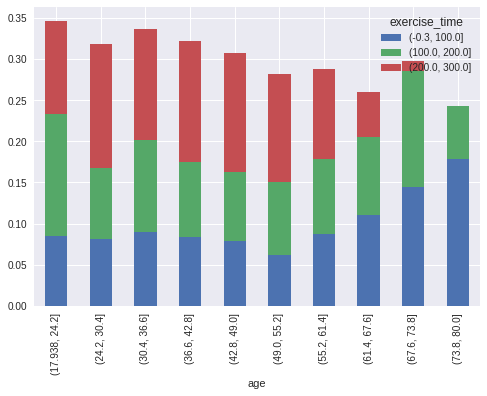

In [65]:

pd.crosstab(age_bins, exercise_bins, normalize='columns').plot(kind='bar', stacked=True)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

    Each of the variables (as measured here) is discrete; the UUID is quite naturally discrete, while the others are more or less continuous variables that have been binned.

2.  What are the relationships between the variables?

    Age and weight both impose an upper limit on the number of minutes worked out/exert a downward influence on time spent exercising.

3.  Which relationships are "real", and which spurious?

    There's a lot to be said here. Obviously, old age exerts a downward influence on exercise time since old people are fragile, but the relationship is not super clear until the older brackets. In fact, there's quite a bit of variation up until the last two age groups.

    The relationship between weight and exercise time is much more difficult to tease out--much more confounded. We can tell almost any causal story we want absent more information. For example: overweight people might be more likely to exercise due to insecurity, societal pressure, desire to be healthier, etc. Overweight people might be less likely to exercise due to insecurity, societal pressure, inertia, bad habits, etc. People who exercise might be more likely to be in shape (or at least have a low weight) *because* they exercise. People who have relatively low weight because they might not think of themselves as *needing* to exercise in the same way that overweight people often do.

    None of these explanations take into account probably the most significant missing confounder here: overall physical health.Weight by itself is not a great metric of overall health since, for example, 120 lbs is a perfectly reasonable weight for someone who's 5'2", but would be quite dire indeed for someone who's 6'8". Similarly, a body-builder might weigh quite a bit more than the average weight for their height--might indeed be classified as overweight or even obese based on their BMI, a flawed metric for similar reasons--but be in better than average shape--and, of course, would probably exercise fairly frequently.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)